<a href="https://colab.research.google.com/github/Zero-Rae/QCES123/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [64]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [65]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [66]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [67]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [98]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [69]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.08 seconds


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

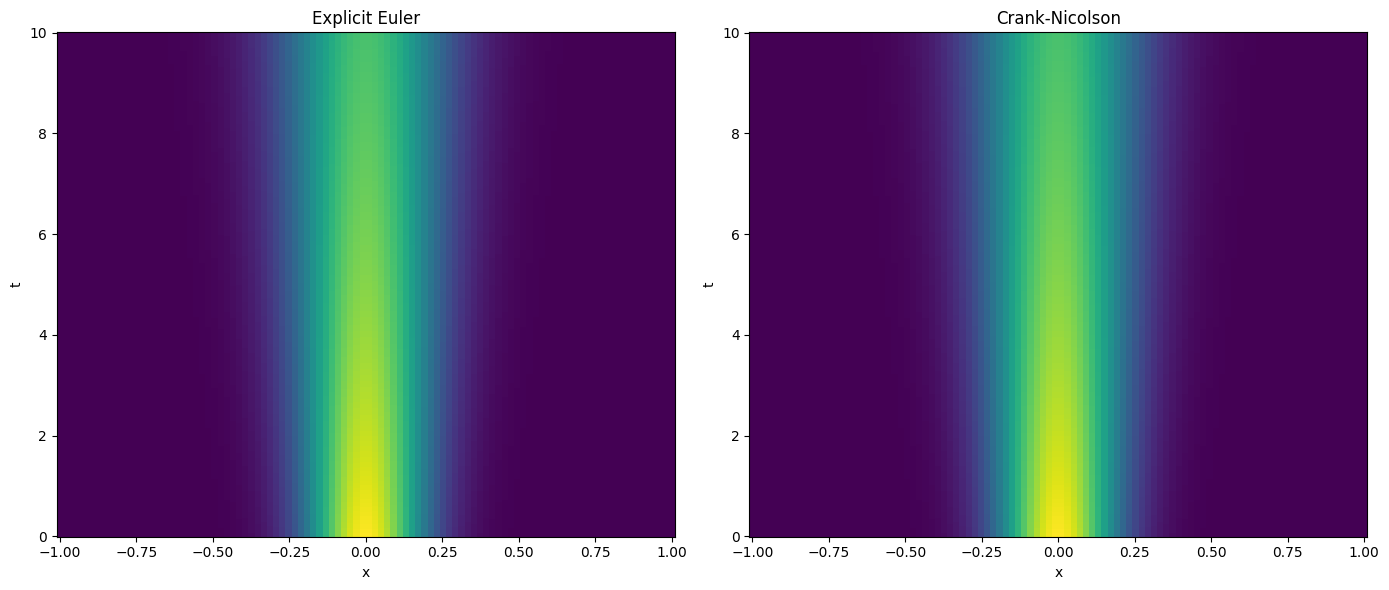

In [70]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing Nx (decreasing the grid spacing, $\Delta x$) and/or increase the diffusivity, $\kappa$, and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

When the time step $\Delta t$ is fixed and either the number of grid points $N_x$ or the diffusivity $\kappa$ is increased, the Explicit Euler method often tends toward instability, whereas the Crank–Nicolson method remains stable under the same conditions. In the pcolormesh plots generated for three values of $\kappa$ ($0.1, 0.01, 0.001$) and three values of $N_x$ ($100, 200, 500$) below, Crank–Nicolson consistently demonstrates smooth and gradual diffusion profiles under the chosen parameters, highlighting its stability. When $N_x$ is fixed, increasing $\kappa$ results in faster propagation of the diffusion profile，and instabilities occur for some bigger $\kappa$. For example, at $N_x = 100$, the Explicit Euler method remains stable for $\kappa = 0.001$ and $\kappa = 0.01$, but becomes unstable for $\kappa = 0.1$, where the color scale shows clipped values, indicating extremely large values or NaN. Conversely, when $\kappa$ is fixed, increasing $N_x$ improves the resolution but can lead to instability in the Explicit Euler method. For instance, at $\kappa = 0.001$, Explicit Euler is stable for $N_x = 100$ and $N_x = 200$, but at $N_x = 500$, the plot displays a uniform green region, indicating instability.
 The outcome can be explained by the Courant–Friedrichs–Lewy (CFL) condition. Applying an explicit (forward) time difference and a second-order central difference in space to the diffusion equation
$\displaystyle \frac{\partial c}{\partial t} \;=\; \kappa\,\frac{\partial^2 c}{\partial x^2}$
produces the discrete update formula $\displaystyle c_i^{n+1} \;=\; c_i^n \;+\; \frac{\kappa\,\Delta t}{\Delta x^2}\,\bigl(c_{i+1}^n \;-\; 2\,c_i^n \;+\; c_{i-1}^n\bigr)\,.$
Analyzing stability by assuming the solution at each timestep is a sum of Fourier modes and focusing on a single mode $c_i^n = e^{\,i\,k\,x_i}\,g^n$ shows that the amplification factor $|g|$ must remain at or below 1 to avoid divergence, yielding the CFL condition $\displaystyle \Delta t \;\le\; \frac{\Delta x^2}{2\,\kappa}$.When $\Delta t$ is fixed, increasing $N_x$ or $\kappa$ can both lead to instability in the Explicit Euler method.








<ipython-input-65-21a1127dc7c6>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.14 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.13 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.13 seconds
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.59 seconds
Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.62 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.80 seconds


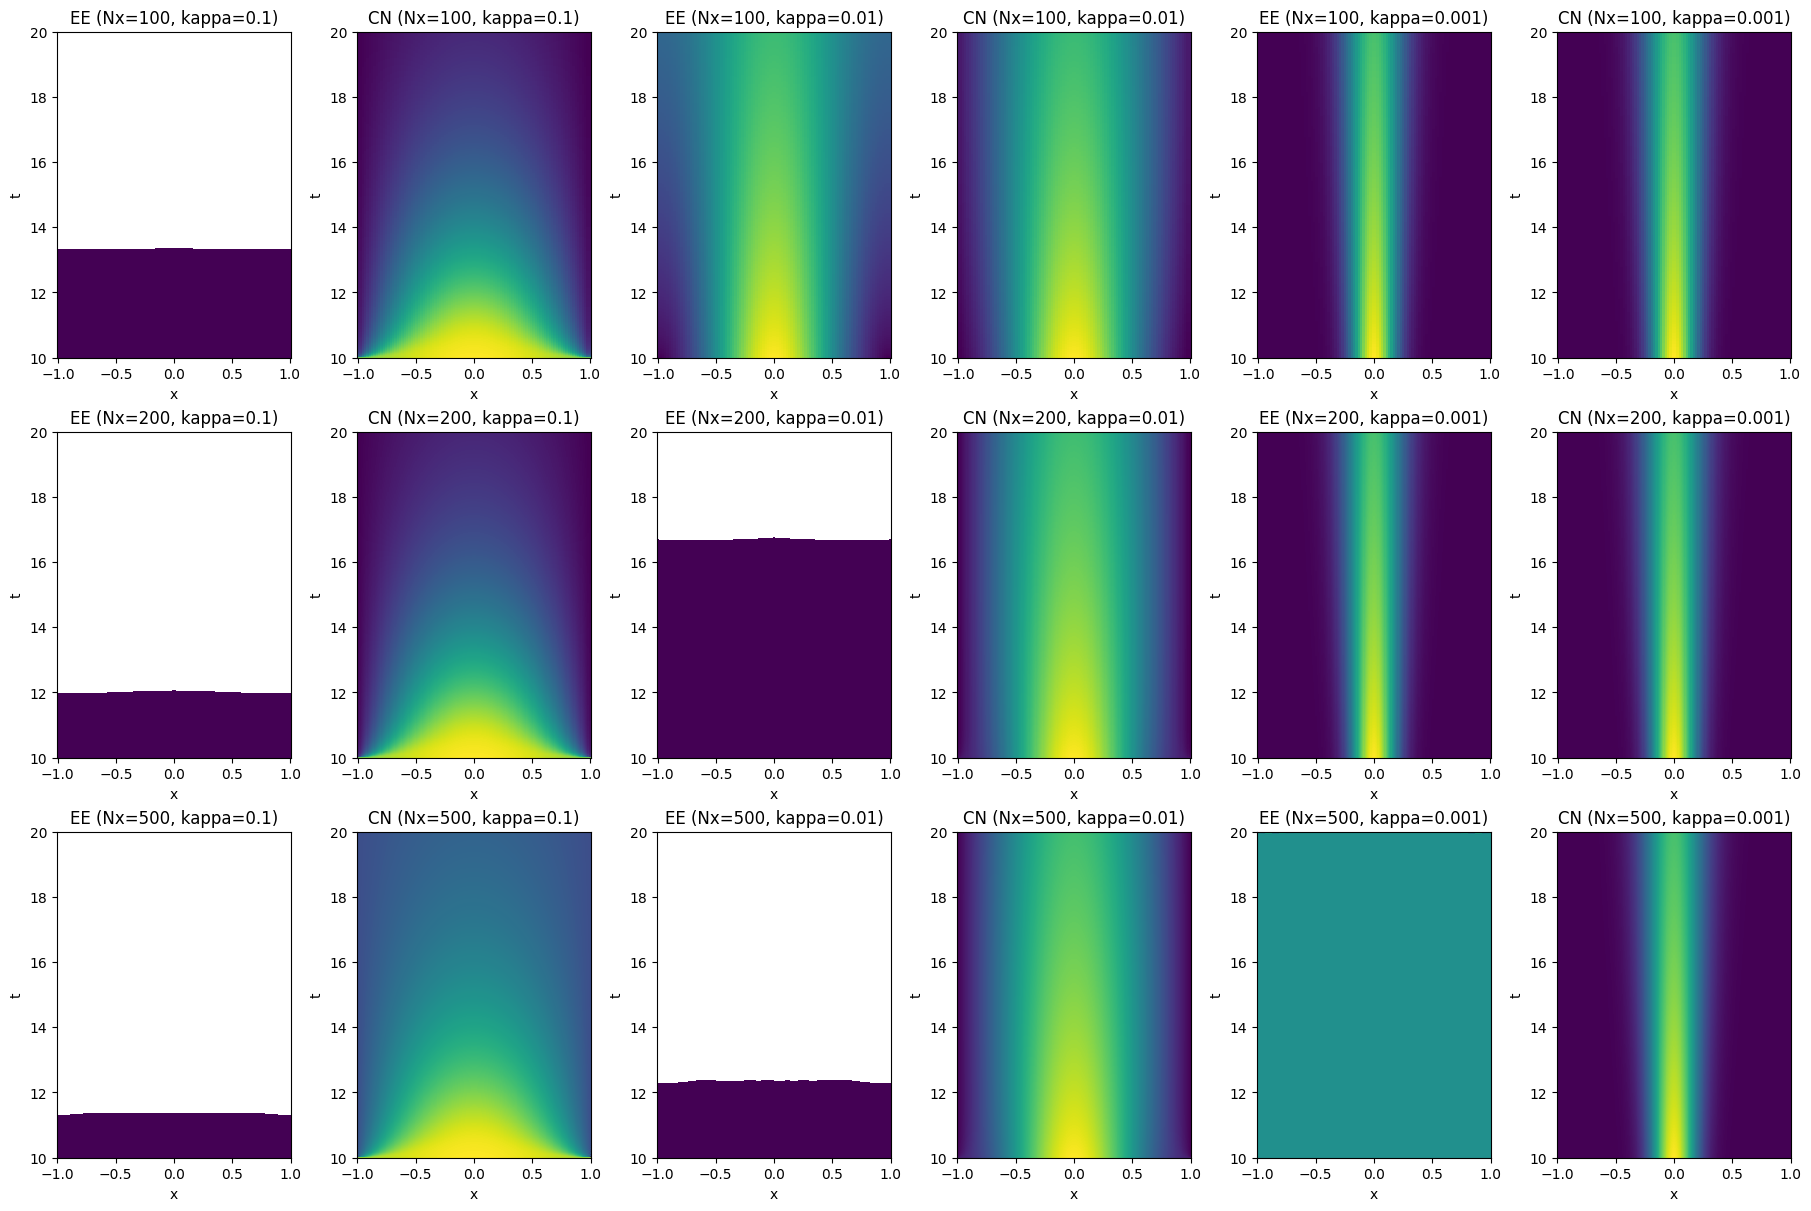

In [110]:
#@title #Plots
kappa_values = [0.1, 0.01, 0.001]
Nx_values = [100, 200, 500]
Nt = 1000

t_start, t_end, Nt = 10, 20, 1000
x_start, x_end = -1, 1

# Create a figure with 3 rows (one for each Nx) and 6 columns (each row has 3 pairs of subplots, each pair shows EE and CN results for a given kappa).
fig, axes = plt.subplots(
    nrows=len(Nx_values),
    ncols=len(kappa_values)*2,
    figsize=(18, 12),
    constrained_layout=True
)

# For loop
for row, Nx in enumerate(Nx_values):
    # Generate the spatial and temporal grids
    x = np.linspace(x_start, x_end, Nx)
    t = np.linspace(t_start, t_end, Nt)

    # Loop over each kappa in kappa_values
    for col, kappa in enumerate(kappa_values):
        # Compute solutions using Explicit Euler (EE) and Crank-Nicolson (CN)
        c_EE = EE(x, t, kappa)
        c_CN = CN(x, t, kappa)

        ax_left = axes[row, 2*col]
        ax_right = axes[row, 2*col + 1]

        # Plot the solution as a pcolormesh for EE and CN
        pcm_left = ax_left.pcolormesh(
            x, t, c_EE.T, shading='auto', cmap='viridis'
        )

        pcm_right = ax_right.pcolormesh(
            x, t, c_CN.T, shading='auto', cmap='viridis'
        )

        ax_left.set_title(f'EE (Nx={Nx}, kappa={kappa})')
        ax_right.set_title(f'CN (Nx={Nx}, kappa={kappa})')

        ax_left.set_xlabel('x')
        ax_left.set_ylabel('t')
        ax_right.set_xlabel('x')
        ax_right.set_ylabel('t')

plt.show()


### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds


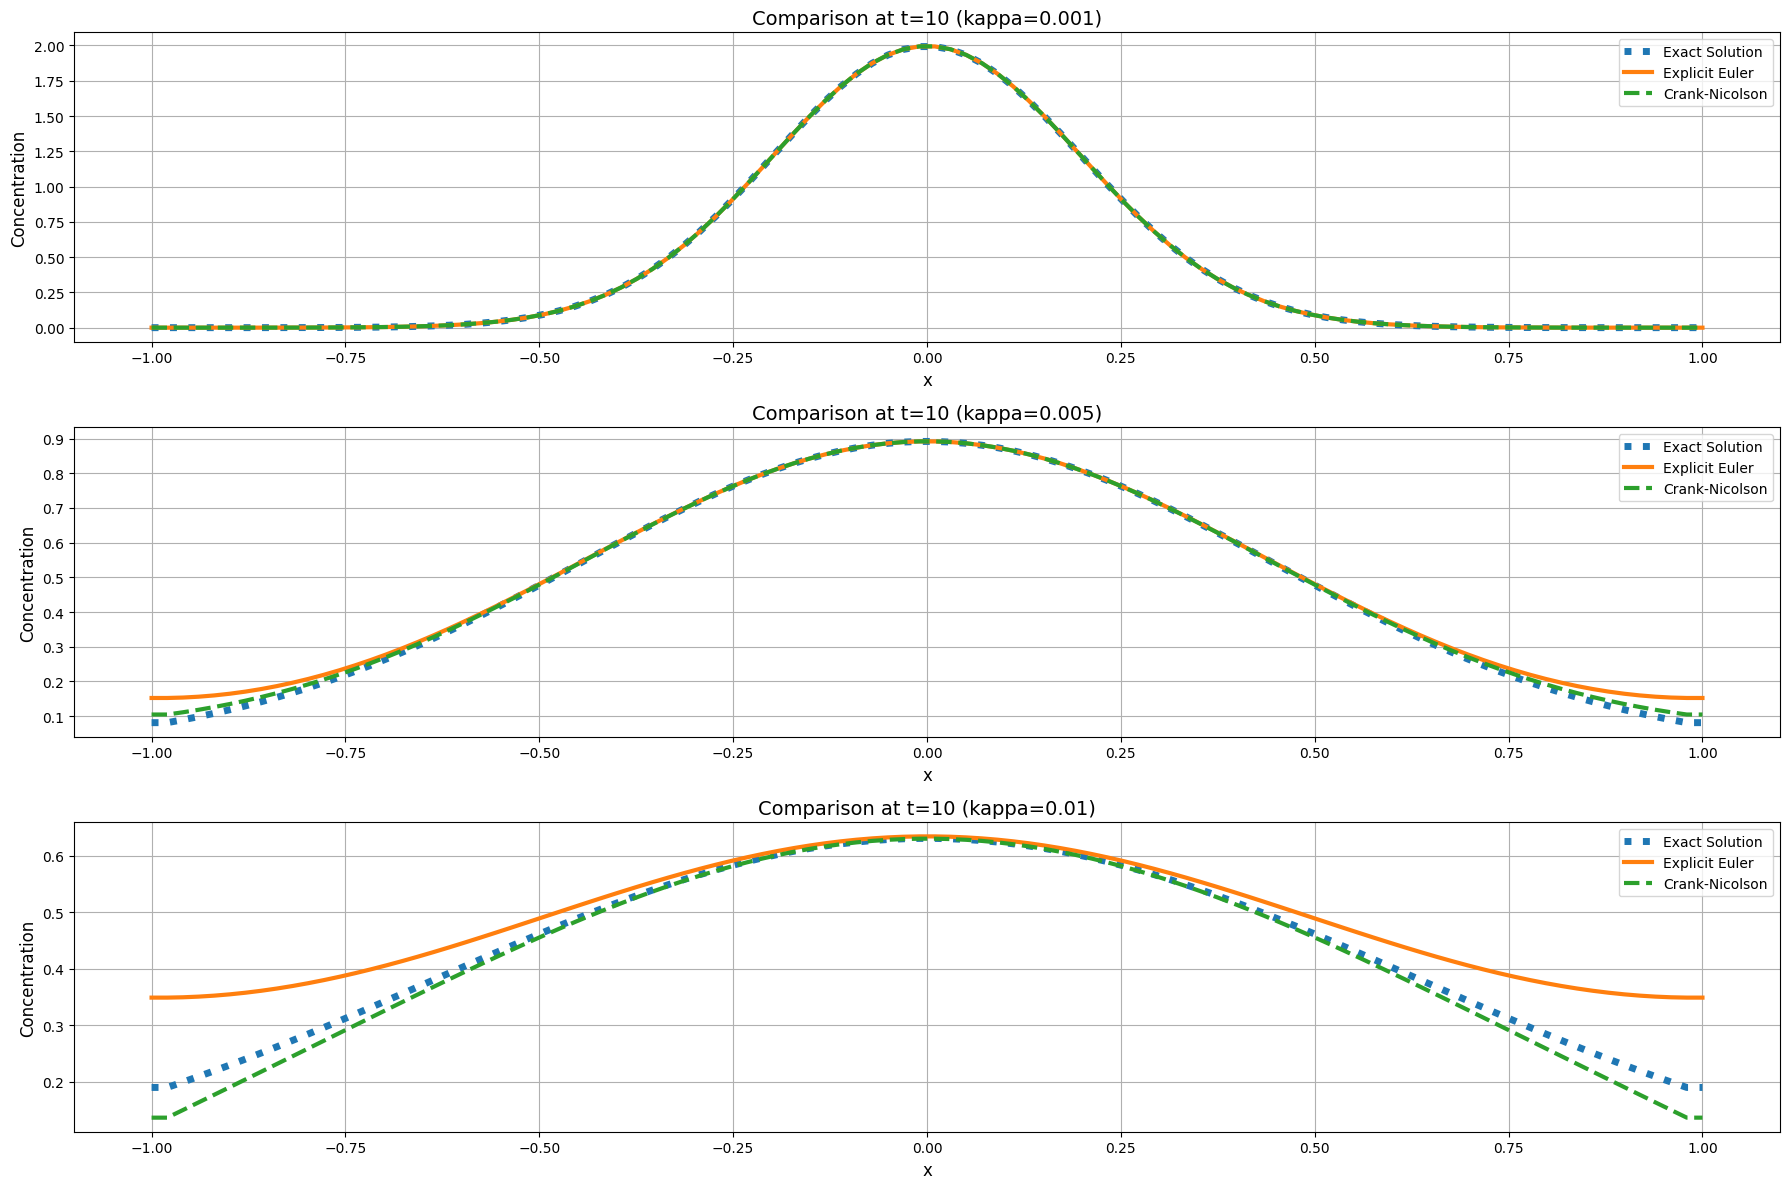

In [105]:
# Parameters changed to match the ICs of the exact solution
t_start = 10
t_end = 20
kappa_values = [0.001, 0.005, 0.01]  # Different diffusivity values


plt.figure(figsize=(18, 12))


for i, kappa in enumerate(kappa_values):
    # Compute solutions
    c_exact = set_ics(x, kappa, t_end)  # Exact solution
    c_EE = EE(x, np.linspace(t_start, t_end, 1000), kappa)[:, -1]  # Explicit Euler
    c_CN = CN(x, np.linspace(t_start, t_end, 1000), kappa)[:, -1]  # Crank-Nicolson


    plt.subplot(3, 1, i + 1)
    plt.plot(x, c_exact, label='Exact Solution', linestyle='dotted', linewidth=5)
    plt.plot(x, c_EE, label='Explicit Euler', linestyle='-', linewidth=3)
    plt.plot(x, c_CN, label='Crank-Nicolson', linestyle='--', linewidth=3)
    plt.title(f'Comparison at t=10 (kappa={kappa})', fontsize=14)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('Concentration', fontsize=12)
    plt.legend()
    plt.grid()


plt.tight_layout()
plt.show()











Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

使用kappa=0.001*和RMSE*

Explicit Euler method took 0.15 seconds
Crank-Nicolson method took 0.13 seconds
Explicit Euler method took 0.29 seconds
Crank-Nicolson method took 0.17 seconds
Explicit Euler method took 0.13 seconds
Crank-Nicolson method took 0.24 seconds
Explicit Euler method took 0.14 seconds
Crank-Nicolson method took 0.37 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.19 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.27 seconds
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.39 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.50 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.07 seconds


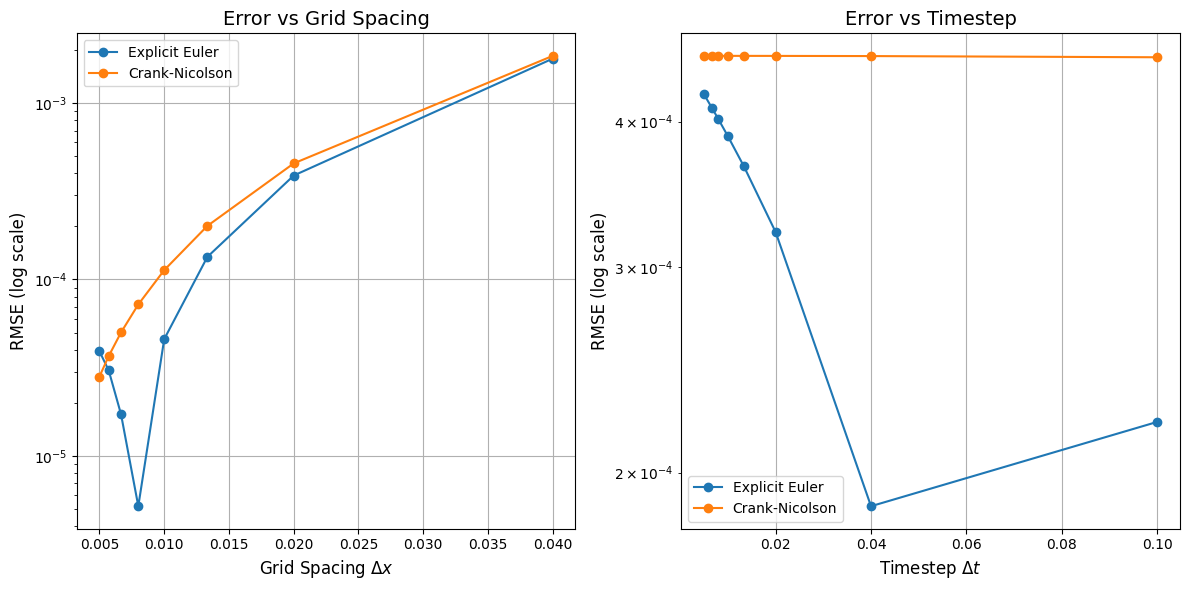

In [114]:
# Define RMSE function
def compute_rmse(numerical_solution, exact_solution):
    Nx = len(numerical_solution)
    return np.sqrt(np.sum((numerical_solution - exact_solution) ** 2) / Nx)

# Parameters
kappa = 0.001  # Diffusivity
t_start = 10
t_end = 20

# Error as a function of Δx (grid spacing)
Nx_values = [50, 100, 150, 200, 250, 300, 350, 400]  # Different grid resolutions
errors_EE_dx = []
errors_CN_dx = []

for Nx in Nx_values:
    x = np.linspace(-1, 1, Nx)
    t = np.linspace(t_start, t_end, 1000)
    c_exact = set_ics(x, kappa, t_end)
    c_EE = EE(x, t, kappa)[:, -1]
    c_CN = CN(x, t, kappa)[:, -1]
    errors_EE_dx.append(compute_rmse(c_EE, c_exact))
    errors_CN_dx.append(compute_rmse(c_CN, c_exact))

# Error as a function of Δt (timestep)
Nt_values = [100, 250, 500, 750, 1000, 1250, 1500, 2000]  # Different time resolutions
errors_EE_dt = []
errors_CN_dt = []

for Nt in Nt_values:
    x = np.linspace(-1, 1, 100)  # Fixed spatial resolution
    t = np.linspace(t_start, t_end, Nt)  # Temporal grid
    c_exact = set_ics(x, kappa, t_end)  # Exact solution
    c_EE = EE(x, t, kappa)[:, -1]  # Explicit Euler
    c_CN = CN(x, t, kappa)[:, -1]  # Crank-Nicolson
    errors_EE_dt.append(compute_rmse(c_EE, c_exact))
    errors_CN_dt.append(compute_rmse(c_CN, c_exact))

# Plot RMSE vs Δx (grid spacing)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot((2 / np.array(Nx_values)), errors_EE_dx, label='Explicit Euler', marker='o')
plt.plot((2 / np.array(Nx_values)), errors_CN_dx, label='Crank-Nicolson', marker='o')
plt.xlabel(r'Grid Spacing $\Delta x$', fontsize=12)
plt.ylabel('RMSE (log scale)', fontsize=12)
plt.title('Error vs Grid Spacing', fontsize=14)
plt.yscale('log')  # Set log scale for y-axis
plt.legend()
plt.grid()

# Plot RMSE vs Δt (timestep)
plt.subplot(1, 2, 2)
plt.plot((t_end - t_start) / np.array(Nt_values), errors_EE_dt, label='Explicit Euler', marker='o')
plt.plot((t_end - t_start) / np.array(Nt_values), errors_CN_dt, label='Crank-Nicolson', marker='o')
plt.xlabel(r'Timestep $\Delta t$', fontsize=12)
plt.ylabel('RMSE (log scale)', fontsize=12)
plt.title('Error vs Timestep', fontsize=14)
plt.yscale('log')  # Set log scale for y-axis
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?